In [ ]:
!pip install pykeen
!pip install rdflib
import time
import numpy as np
from pykeen.triples import TriplesFactory
from rdflib import Graph
import pandas as pd
from pykeen.pipeline import pipeline
import torch
from sklearn.model_selection import train_test_split
from google.colab import drive
from pykeen.predict import predict_triples
from pykeen.datasets import get_dataset
from pykeen.evaluation import RankBasedEvaluator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.0/704.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-ma

INFO:pykeen.utils:Using opt_einsum


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class KGTransEmbeddor:
    def __init__(self):
        self.ttl = None
        self.graph = None
        self.triples = None
        self.df = None
        self.train_df = None
        self.test_df = None
        self.train_triples = None
        self.test_triples = None
        self.result = None
        self.model = None
        self.rec_accuracy = None

    def fit(self, ttl):
        self.ttl = ttl
        start = time.time()
        print(f"Loading data from {ttl}...")
        self.create_graph()
        print(f"Data loaded in {time.time() - start:.2f} seconds")
        start = time.time()
        print("Preprocessing data...")
        self.create_df()
        self.preprocess()
        print(f"Data preprocessed in {time.time() - start:.2f} seconds")
        start = time.time()
        print("Training model...")
        self.train_model()
        print(self.result.metric_results)
        print(f"Model fit in {time.time() - start:.2f} seconds")


    def create_graph(self):
        g = Graph()
        g.parse(self.ttl, format="turtle")

        triples = []
        for subj, pred, obj in g:
            triples.append((str(subj), str(pred), str(obj)))

        self.triples = triples
        self.graph = g

    def create_df(self):
        if not hasattr(self, 'triples'):
            self.create_graph()
        self.df = pd.DataFrame(self.triples, columns=["head", "relation", "tail"])

    def preprocess(self):
        if not hasattr(self, 'df'):
            self.create_df()
        self.df['head'] = self.df['head'].apply(self.shrink)
        self.df['relation'] = self.df['relation'].apply(self.shrink)
        self.df['tail'] = self.df['tail'].apply(self.shrink)

    def shrink(self, uri):
        uri = uri.removeprefix("http://sdmlab2.org/")
        uri = uri.split('#')[-1]
        return uri

    def train_model(self):
        # Split the data into training and test sets
        self.train_df, valtest = train_test_split(self.df, test_size=0.3, random_state=42)
        self.val_df, self.test_df = train_test_split(valtest, test_size=0.5, random_state=42)

        # Create TriplesFactory for training and testing
        self.train_triples = TriplesFactory.from_labeled_triples(self.train_df.values)
        self.test_triples = TriplesFactory.from_labeled_triples(self.test_df.values)
        self.val_triples = TriplesFactory.from_labeled_triples(self.val_df.values)

        # Define and train the model using the PyKEEN pipeline
        result = pipeline(
            training=self.train_triples,
            testing=self.val_triples,
            model='TransE',
            training_kwargs=dict(num_epochs=100),
            device='cuda'
        )

        # Get the trained model
        self.result = result
        self.model = result.model

        # save model
        torch.save(self.model, f'/content/drive/My Drive/Y1S2_2024/Semantic_Data_Management/model-{time.time()}.pth')

    def eval(self):
      evaluator = RankBasedEvaluator()
      metrics = evaluator.evaluate(self.model, self.test_triples.mapped_triples, additional_filter_triples=[self.train_triples.mapped_triples, self.val_triples.mapped_triples])
      print(f"Hits@1: {metrics.get_metric('hits@1')}")
      print(f"Hits@3: {metrics.get_metric('hits@3')}")
      print(f"Hits@5: {metrics.get_metric('hits@5')}")
      print(f"Hits@10: {metrics.get_metric('hits@10')}")
      print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

    def plot(self):
      num_samples = 5000  # samples to plot
      sampled_indices = np.random.choice(len(self.train_triples.triples), size=num_samples, replace=False)
      sampled_triples = self.train_triples.triples[sampled_indices]

      # Get unique entities
      unique_entities = np.unique(np.concatenate((sampled_triples[:, 0], sampled_triples[:, 2])))
      entity_types = [str(entity).split("/")[0] if "/" in str(entity) else "Literal" for entity in unique_entities]

      entity_embeddings = self.model.state_dict()['entity_representations.0._embeddings.weight'].cpu().numpy()

      # Create a mapping from entity IDs to indices in the entity embeddings array
      entity_id_to_index = {entity_id: index for index, entity_id in enumerate(self.train_triples.entity_to_id.keys())}

      # Filter entity embeddings for sampled entities
      sampled_entity_embeddings = np.array([entity_embeddings[entity_id_to_index[entity_id]] for entity_id in unique_entities])

      # Reduce dimensionality using t-SNE
      tsne = TSNE(n_components=2, n_iter=250)
      embeddings_2d = tsne.fit_transform(entity_embeddings)

      # Get unique class labels
      unique_classes = ["Author", "Company", "ConfWork", "Journal", "Keyword", "Literal", "Paper", "Proceeding", "Review", "Topic", "University", "Volume"] #list(np.unique(entity_types))

      # Assign a distinct color to each class label
      colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

      # Create a color map for class labels
      class_color_map = {class_label: color for class_label, color in zip(unique_classes, colors)}

      # Plot the embeddings with colors based on class labels
      plt.figure(figsize=(10, 8))
      for i, class_label in enumerate(entity_types):
          plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=class_color_map[class_label], s=10)

      legend_handles = []
      for class_label, color in class_color_map.items():
          legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markersize=7, label=class_label, markerfacecolor=color))

      plt.legend(handles=legend_handles, loc='upper right')
      plt.title('Entity Embeddings Visualization (t-SNE)')
      plt.xlabel('t-SNE Component 1')
      plt.ylabel('t-SNE Component 2')
      plt.show()

In [ ]:
# Load the RDF data
ttl = '/content/drive/MyDrive/Y1S2_2024/Semantic_Data_Management/data.ttl'

# Create a reviewer recommender
transe = KGTransEmbeddor()

# Fit the recommender to the data
transe.fit(ttl)

Loading data from /content/drive/MyDrive/Y1S2_2024/Semantic_Data_Management/data.ttl...
Data loaded in 45.91 seconds
Preprocessing data...
Data preprocessed in 1.01 seconds
Training model...


INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1915 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/105k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 100.41s seconds


Model fit in 1372.93 seconds


In [ ]:
transe.eval()

Evaluating on cuda:0:   0%|          | 0.00/105k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 105.12s seconds


Hits@1: 9.519910893634036e-06
Hits@3: 5.235950991498719e-05
Hits@5: 8.567919804270632e-05
Hits@10: 0.00019991812876631474
Mean Reciprocal Rank: 0.00019729550695046782


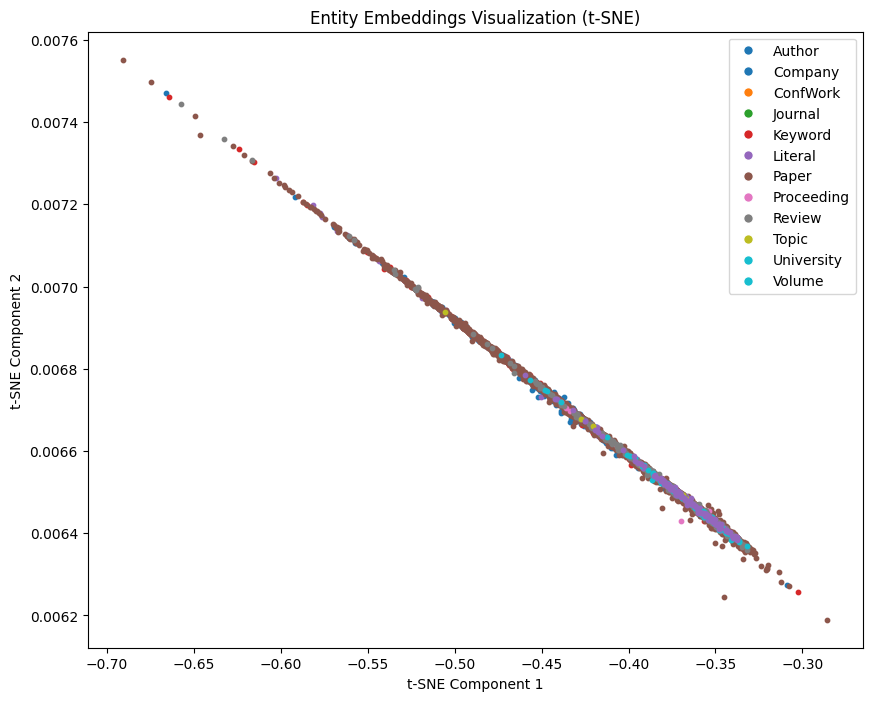

In [ ]:
transe.plot()